# Day26 Option Comparison: LLM vs English1000


Compare within-subject performance between LLM embeddings and English1000+word2vec across runs, smoothing windows, and semantic categories. The notebook writes per-run delta heatmaps and summary plots without mixing data across runs or options.

In [1]:
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---

ROOT_SUBJECT_DIR = Path('/flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02')
SUBJECT_OVERRIDE = None

STORY_FILTERS = None  # e.g. ['wheretheressmoke']
RUN_FILTERS = None    # e.g. ['run-1', 'run-2']

OPTION_LLM_NAME = 'day26_smoothing_cli_MDE_llm_CAE'
OPTION_BASE_NAME = 'day26_smoothing_cli_MDE90step_detrend_gaussian_CAE'
OPTION_LLM_LABEL = 'LLM'
OPTION_BASE_LABEL = 'English1000'

METRICS = [
    ('rho', 'rho', 'rho_test', 3, 'higher'),
    ('CAE', 'cae', 'cae_test', 2, 'lower'),
    ('RMSE', 'rmse', 'rmse_test', 3, 'lower'),
]

WINDOW_SELECT_METRIC_KEY = 'cae'
WINDOW_SELECT_SPLIT = 'validation'
WINDOW_SELECT_PER_OPTION = True

CATEGORIES_DISPLAY = [
    'Abstract', 'Communal', 'Emotional', 'Locational', 'Mental', 'Numeric',
    'Professional', 'Social', 'Tactile', 'Temporal', 'Violent', 'Visual'
]

VALID_WINDOW_PREFIXES = ('none_', 'movavg_', 'gauss_', 'guass_')
LAG_OPTIONS = ('lag', 'nolag')

PLOT_WINDOW_STRATIFIED = True
PLOT_MEAN_SUMMARIES = True
PLOT_BEST_WINDOW_SUMMARIES = True
PLOT_OVERALL_WINS = True
SAVE_BEST_WINDOW_TABLE = True



In [2]:


def matches_filters(value: str, filters: Optional[Sequence[str]]) -> bool:
    if not filters:
        return True
    return value in filters


def slugify(value: str) -> str:
    cleaned = []
    for ch in value:
        if ch.isalnum():
            cleaned.append(ch.lower())
        elif ch in ('-', '_'):
            cleaned.append(ch)
        else:
            cleaned.append('_')
    return ''.join(cleaned)


def resolve_subject(root_dir: Path, override: Optional[str]) -> str:
    return override or root_dir.name


def iter_story_runs(
    root_dir: Path,
    story_filters: Optional[Sequence[str]],
    run_filters: Optional[Sequence[str]],
):
    for story_dir in sorted(root_dir.iterdir()):
        if not story_dir.is_dir():
            continue
        if not matches_filters(story_dir.name, story_filters):
            continue
        for run_dir in sorted(story_dir.iterdir()):
            if not run_dir.is_dir():
                continue
            if not matches_filters(run_dir.name, run_filters):
                continue
            yield story_dir.name, run_dir.name, run_dir


def run_sort_key(run_name: str):
    digits = ''.join(ch for ch in run_name if ch.isdigit())
    if digits:
        return (int(digits), run_name)
    return (float('inf'), run_name)


def split_window_and_lag(name: str):
    for lag in LAG_OPTIONS:
        suffix = f"_{lag}"
        if name.endswith(suffix):
            return name[: -len(suffix)], lag
    return name, None


def window_numeric_value(window: str) -> float:
    if '_' not in window:
        return float('inf')
    numeric_part = window.split('_', 1)[1].replace('p', '.')
    try:
        return float(numeric_part)
    except ValueError:
        return float('inf')


def window_sort_key_with_lag(window: str):
    base, lag = split_window_and_lag(window)
    lag_order = 0 if lag is None else (1 if lag == 'lag' else 2)
    return (window_numeric_value(base), lag_order, window)


def discover_windows_from_summaries(
    option_dir: Path,
    metric_key: str,
    valid_prefixes: Sequence[str],
) -> List[str]:
    windows = set()
    suffix = f"_{metric_key}_summary.csv"
    for csv_path in option_dir.glob(f"*{suffix}"):
        base_name = csv_path.name.replace(suffix, '')
        base_window, _ = split_window_and_lag(base_name)
        if not base_window.startswith(tuple(valid_prefixes)):
            continue
        windows.add(base_name)
    return sorted(windows, key=window_sort_key_with_lag)


def format_category_name(raw_category: str) -> str:
    return raw_category.replace('cat_', '').replace('_', ' ').title()


def read_metric_csv(csv_path: Path, metric_key: str, split: str) -> Optional[pd.DataFrame]:
    if not csv_path.exists():
        return None
    df = pd.read_csv(csv_path)
    preferred = f"{metric_key}_{split}"
    if preferred in df.columns:
        col = preferred
    else:
        col = df.columns[-1]
    df = df[['category', col]].copy()
    df.rename(columns={col: 'value'}, inplace=True)
    return df


def build_metric_table(
    option_dir: Path,
    windows: Sequence[str],
    metric_key: str,
    split: str,
    categories: Sequence[str],
) -> pd.DataFrame:
    rows = []
    index = []
    for window in windows:
        csv_path = option_dir / f"{window}_{metric_key}_summary.csv"
        metric_df = read_metric_csv(csv_path, metric_key, split)
        row = {cat: np.nan for cat in categories}
        if metric_df is not None:
            for _, row_data in metric_df.iterrows():
                pretty = format_category_name(str(row_data['category']))
                if pretty in row:
                    row[pretty] = row_data['value']
        rows.append(row)
        index.append(window)
    return pd.DataFrame(rows, index=index, columns=list(categories))


def safe_nanmean(values: np.ndarray) -> float:
    values = np.asarray(values, dtype=float)
    if values.size == 0 or np.isnan(values).all():
        return float('nan')
    return float(np.nanmean(values))


def compute_category_means(df: pd.DataFrame, categories: Sequence[str]) -> Dict[str, float]:
    means = {}
    for cat in categories:
        if cat not in df.columns:
            means[cat] = float('nan')
            continue
        means[cat] = safe_nanmean(df[cat].to_numpy(dtype=float))
    return means


def select_best_windows(
    selection_df: pd.DataFrame,
    preference: str,
    categories: Sequence[str],
) -> Dict[str, str]:
    best = {}
    for cat in categories:
        if cat not in selection_df.columns:
            continue
        series = selection_df[cat]
        if series.isna().all():
            continue
        if preference == 'higher':
            best_idx = series.idxmax()
        else:
            best_idx = series.idxmin()
        if pd.isna(best_idx):
            continue
        best[cat] = str(best_idx)
    return best


def extract_values_at_windows(
    test_df: pd.DataFrame,
    best_windows: Dict[str, str],
    categories: Sequence[str],
) -> List[float]:
    values = []
    for cat in categories:
        window = best_windows.get(cat)
        if window is None or window not in test_df.index:
            values.append(float('nan'))
            continue
        values.append(float(test_df.loc[window, cat]))
    return values


def plot_side_by_side_bars(
    labels: Sequence[str],
    values_a: Sequence[float],
    values_b: Sequence[float],
    label_a: str,
    label_b: str,
    title: str,
    ylabel: str,
    output_path: Path,
):
    x = np.arange(len(labels))
    width = 0.4
    values_a = np.nan_to_num(np.array(values_a, dtype=float), nan=0.0)
    values_b = np.nan_to_num(np.array(values_b, dtype=float), nan=0.0)

    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.6), 3.5))
    ax.bar(x - width / 2, values_a, width, label=label_a, color='#4c78a8')
    ax.bar(x + width / 2, values_b, width, label=label_b, color='#f58518')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=12)
    ax.legend()
    fig.tight_layout()

    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close(fig)


def compare_values(val_a: float, val_b: float, preference: str) -> Optional[str]:
    if not np.isfinite(val_a) or not np.isfinite(val_b):
        return None
    if np.isclose(val_a, val_b, atol=1e-12, rtol=1e-6):
        return None
    if preference == 'higher':
        return OPTION_LLM_LABEL if val_a > val_b else OPTION_BASE_LABEL
    return OPTION_LLM_LABEL if val_a < val_b else OPTION_BASE_LABEL


def plot_win_counts(
    labels: Sequence[str],
    wins_a: Sequence[int],
    wins_b: Sequence[int],
    label_a: str,
    label_b: str,
    title: str,
    output_path: Path,
):
    x = np.arange(len(labels))
    width = 0.4
    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.6), 3.5))
    ax.bar(x - width / 2, wins_a, width, label=label_a, color='#4c78a8')
    ax.bar(x + width / 2, wins_b, width, label=label_b, color='#f58518')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Metric wins')
    ax.set_title(title, fontsize=12)
    ax.legend()
    fig.tight_layout()

    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close(fig)


Skipping wheretheressmoke / option_comparison_day26_smoothing_cli_mde_llm_cae_vs_day26_smoothing_cli_mde90step_detrend_gaussian_cae_summary: missing option directories.
=== wheretheressmoke / run-1 ===
LLM dir : /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE_llm_CAE
Base dir: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-1/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE
=== wheretheressmoke / run-2 ===
LLM dir : /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-2/day26_smoothing_cli_MDE_llm_CAE
Base dir: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS02/wheretheressmoke/run-2/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE


KeyboardInterrupt: 

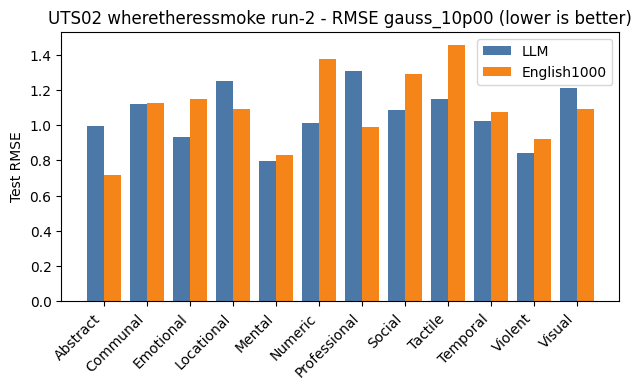

In [3]:
# --- Run comparisons ---

if not ROOT_SUBJECT_DIR.exists():
    raise FileNotFoundError(f"ROOT_SUBJECT_DIR does not exist: {ROOT_SUBJECT_DIR}")

subject = resolve_subject(ROOT_SUBJECT_DIR, SUBJECT_OVERRIDE)
comparison_tag = f"{slugify(OPTION_LLM_NAME)}_vs_{slugify(OPTION_BASE_NAME)}"

metric_lookup = {m[1]: m for m in METRICS}
select_metric = metric_lookup.get(WINDOW_SELECT_METRIC_KEY)
if select_metric is None:
    raise ValueError(f"Unknown WINDOW_SELECT_METRIC_KEY: {WINDOW_SELECT_METRIC_KEY}")

select_preference = select_metric[4]

summary_by_story: Dict[str, Dict[str, Dict[str, object]]] = {}

for story, run, run_dir in iter_story_runs(ROOT_SUBJECT_DIR, STORY_FILTERS, RUN_FILTERS):
    llm_dir = run_dir / OPTION_LLM_NAME
    base_dir = run_dir / OPTION_BASE_NAME

    if not llm_dir.exists() or not base_dir.exists():
        print(f"Skipping {story} / {run}: missing option directories.")
        continue

    output_dir = run_dir / f"option_comparison_{comparison_tag}"
    output_dir.mkdir(parents=True, exist_ok=True)

    story_summary = summary_by_story.setdefault(story, {})

    print(f"=== {story} / {run} ===")
    print(f"LLM dir : {llm_dir}")
    print(f"Base dir: {base_dir}")

    llm_windows = discover_windows_from_summaries(llm_dir, WINDOW_SELECT_METRIC_KEY, VALID_WINDOW_PREFIXES)
    base_windows = discover_windows_from_summaries(base_dir, WINDOW_SELECT_METRIC_KEY, VALID_WINDOW_PREFIXES)
    windows = sorted(set(llm_windows) & set(base_windows), key=window_sort_key_with_lag)

    if not windows:
        print("  No shared windows found; skipping run.")
        continue

    llm_select_df = build_metric_table(
        llm_dir,
        windows,
        WINDOW_SELECT_METRIC_KEY,
        WINDOW_SELECT_SPLIT,
        CATEGORIES_DISPLAY,
    )
    base_select_df = build_metric_table(
        base_dir,
        windows,
        WINDOW_SELECT_METRIC_KEY,
        WINDOW_SELECT_SPLIT,
        CATEGORIES_DISPLAY,
    )

    llm_best_windows = select_best_windows(llm_select_df, select_preference, CATEGORIES_DISPLAY)
    base_best_windows = select_best_windows(base_select_df, select_preference, CATEGORIES_DISPLAY)

    if not WINDOW_SELECT_PER_OPTION:
        shared_best = base_best_windows
        llm_best_windows = shared_best
        base_best_windows = shared_best

    best_windows_summary = {
        OPTION_LLM_LABEL: llm_best_windows,
        OPTION_BASE_LABEL: base_best_windows,
    }
    if SAVE_BEST_WINDOW_TABLE:
        window_rows = []
        for cat in CATEGORIES_DISPLAY:
            row = {
                'category': cat,
                f'{OPTION_LLM_LABEL}_window': best_windows_summary[OPTION_LLM_LABEL].get(cat),
                f'{OPTION_BASE_LABEL}_window': best_windows_summary[OPTION_BASE_LABEL].get(cat),
            }
            window_rows.append(row)
        window_df = pd.DataFrame(window_rows)
        window_df.to_csv(output_dir / 'best_window_selection.csv', index=False)

    for metric_label, metric_key, preferred_col, fmt_decimals, preference in METRICS:
        llm_test_df = build_metric_table(
            llm_dir,
            windows,
            metric_key,
            'test',
            CATEGORIES_DISPLAY,
        )
        base_test_df = build_metric_table(
            base_dir,
            windows,
            metric_key,
            'test',
            CATEGORIES_DISPLAY,
        )

        mean_llm = safe_nanmean(llm_test_df.to_numpy(dtype=float))
        mean_base = safe_nanmean(base_test_df.to_numpy(dtype=float))

        summary = story_summary.setdefault(metric_key, {
            'mean_run_values': {OPTION_LLM_LABEL: {}, OPTION_BASE_LABEL: {}},
            'mean_category_values': {
                OPTION_LLM_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
                OPTION_BASE_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
            },
            'best_run_values': {OPTION_LLM_LABEL: {}, OPTION_BASE_LABEL: {}},
            'best_category_values': {
                OPTION_LLM_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
                OPTION_BASE_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
            },
            'best_windows': {
                OPTION_LLM_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
                OPTION_BASE_LABEL: {cat: [] for cat in CATEGORIES_DISPLAY},
            },
            'preference': preference,
        })

        summary['mean_run_values'][OPTION_LLM_LABEL][run] = mean_llm
        summary['mean_run_values'][OPTION_BASE_LABEL][run] = mean_base

        llm_cat_means = compute_category_means(llm_test_df, CATEGORIES_DISPLAY)
        base_cat_means = compute_category_means(base_test_df, CATEGORIES_DISPLAY)

        for cat in CATEGORIES_DISPLAY:
            summary['mean_category_values'][OPTION_LLM_LABEL][cat].append(llm_cat_means.get(cat, float('nan')))
            summary['mean_category_values'][OPTION_BASE_LABEL][cat].append(base_cat_means.get(cat, float('nan')))

        best_llm_values = extract_values_at_windows(llm_test_df, llm_best_windows, CATEGORIES_DISPLAY)
        best_base_values = extract_values_at_windows(base_test_df, base_best_windows, CATEGORIES_DISPLAY)

        best_llm_mean = safe_nanmean(np.array(best_llm_values, dtype=float))
        best_base_mean = safe_nanmean(np.array(best_base_values, dtype=float))

        summary['best_run_values'][OPTION_LLM_LABEL][run] = best_llm_mean
        summary['best_run_values'][OPTION_BASE_LABEL][run] = best_base_mean

        for idx, cat in enumerate(CATEGORIES_DISPLAY):
            summary['best_category_values'][OPTION_LLM_LABEL][cat].append(best_llm_values[idx])
            summary['best_category_values'][OPTION_BASE_LABEL][cat].append(best_base_values[idx])

            llm_window = llm_best_windows.get(cat)
            base_window = base_best_windows.get(cat)
            if llm_window:
                summary['best_windows'][OPTION_LLM_LABEL][cat].append(llm_window)
            if base_window:
                summary['best_windows'][OPTION_BASE_LABEL][cat].append(base_window)

        if PLOT_WINDOW_STRATIFIED:
            direction_note = 'higher is better' if preference == 'higher' else 'lower is better'
            for window in windows:
                values_llm = llm_test_df.loc[window].to_list()
                values_base = base_test_df.loc[window].to_list()
                title = f"{subject} {story} {run} - {metric_label} {window} ({direction_note})"
                ylabel = f"Test {metric_label}"
                out_path = output_dir / f"{metric_key}_{window}_side_by_side.png"
                plot_side_by_side_bars(
                    CATEGORIES_DISPLAY,
                    values_llm,
                    values_base,
                    OPTION_LLM_LABEL,
                    OPTION_BASE_LABEL,
                    title,
                    ylabel,
                    out_path,
                )

        if PLOT_BEST_WINDOW_SUMMARIES:
            direction_note = 'higher is better' if preference == 'higher' else 'lower is better'
            title = (
                f"{subject} {story} {run} - {metric_label} best-window test ({direction_note})"
                f"selected by {WINDOW_SELECT_METRIC_KEY} {WINDOW_SELECT_SPLIT}"
            )
            ylabel = f"Test {metric_label}"
            out_path = output_dir / f"best_window_{metric_key}_category_side_by_side.png"
            plot_side_by_side_bars(
                CATEGORIES_DISPLAY,
                best_llm_values,
                best_base_values,
                OPTION_LLM_LABEL,
                OPTION_BASE_LABEL,
                title,
                ylabel,
                out_path,
            )

# --- Story-level summaries and overall wins ---

for story, story_summary in summary_by_story.items():
    summary_dir = ROOT_SUBJECT_DIR / story / f"option_comparison_{comparison_tag}_summary"
    summary_dir.mkdir(parents=True, exist_ok=True)

    print(f"=== Summary for {story} ===")

    for metric_label, metric_key, preferred_col, fmt_decimals, preference in METRICS:
        metric_summary = story_summary.get(metric_key)
        if not metric_summary:
            print(f"  [{metric_label}] No summary data.")
            continue

        direction_note = 'higher is better' if preference == 'higher' else 'lower is better'

        if PLOT_MEAN_SUMMARIES:
            mean_runs = sorted(
                set(metric_summary['mean_run_values'][OPTION_LLM_LABEL]) |
                set(metric_summary['mean_run_values'][OPTION_BASE_LABEL]),
                key=run_sort_key,
            )
            if mean_runs:
                values_llm = [metric_summary['mean_run_values'][OPTION_LLM_LABEL].get(run, float('nan')) for run in mean_runs]
                values_base = [metric_summary['mean_run_values'][OPTION_BASE_LABEL].get(run, float('nan')) for run in mean_runs]
                title = f"{subject} {story} - {metric_label} mean by run ({direction_note})"
                ylabel = f"Mean test {metric_label}"
                out_path = summary_dir / f"run_mean_{metric_key}_side_by_side.png"
                plot_side_by_side_bars(
                    mean_runs,
                    values_llm,
                    values_base,
                    OPTION_LLM_LABEL,
                    OPTION_BASE_LABEL,
                    title,
                    ylabel,
                    out_path,
                )

            labels = CATEGORIES_DISPLAY
            mean_llm = [safe_nanmean(np.array(metric_summary['mean_category_values'][OPTION_LLM_LABEL][cat], dtype=float)) for cat in labels]
            mean_base = [safe_nanmean(np.array(metric_summary['mean_category_values'][OPTION_BASE_LABEL][cat], dtype=float)) for cat in labels]
            title = f"{subject} {story} - {metric_label} mean by category ({direction_note})"
            ylabel = f"Mean test {metric_label}"
            out_path = summary_dir / f"category_mean_{metric_key}_side_by_side.png"
            plot_side_by_side_bars(
                labels,
                mean_llm,
                mean_base,
                OPTION_LLM_LABEL,
                OPTION_BASE_LABEL,
                title,
                ylabel,
                out_path,
            )

        if PLOT_BEST_WINDOW_SUMMARIES:
            best_runs = sorted(
                set(metric_summary['best_run_values'][OPTION_LLM_LABEL]) |
                set(metric_summary['best_run_values'][OPTION_BASE_LABEL]),
                key=run_sort_key,
            )
            if best_runs:
                values_llm = [metric_summary['best_run_values'][OPTION_LLM_LABEL].get(run, float('nan')) for run in best_runs]
                values_base = [metric_summary['best_run_values'][OPTION_BASE_LABEL].get(run, float('nan')) for run in best_runs]
                title = (
                    f"{subject} {story} - {metric_label} best-window test by run ({direction_note})"
                    f"selected by {WINDOW_SELECT_METRIC_KEY} {WINDOW_SELECT_SPLIT}"
                )
                ylabel = f"Test {metric_label}"
                out_path = summary_dir / f"run_best_{metric_key}_side_by_side.png"
                plot_side_by_side_bars(
                    best_runs,
                    values_llm,
                    values_base,
                    OPTION_LLM_LABEL,
                    OPTION_BASE_LABEL,
                    title,
                    ylabel,
                    out_path,
                )

            labels = CATEGORIES_DISPLAY
            best_llm = [safe_nanmean(np.array(metric_summary['best_category_values'][OPTION_LLM_LABEL][cat], dtype=float)) for cat in labels]
            best_base = [safe_nanmean(np.array(metric_summary['best_category_values'][OPTION_BASE_LABEL][cat], dtype=float)) for cat in labels]
            title = (
                f"{subject} {story} - {metric_label} best-window test by category ({direction_note})"
                f"selected by {WINDOW_SELECT_METRIC_KEY} {WINDOW_SELECT_SPLIT}"
            )
            ylabel = f"Test {metric_label}"
            out_path = summary_dir / f"category_best_{metric_key}_side_by_side.png"
            plot_side_by_side_bars(
                labels,
                best_llm,
                best_base,
                OPTION_LLM_LABEL,
                OPTION_BASE_LABEL,
                title,
                ylabel,
                out_path,
            )

        if SAVE_BEST_WINDOW_TABLE:
            summary_rows = []
            for cat in CATEGORIES_DISPLAY:
                llm_windows = metric_summary.get('best_windows', {}).get(OPTION_LLM_LABEL, {}).get(cat, [])
                base_windows = metric_summary.get('best_windows', {}).get(OPTION_BASE_LABEL, {}).get(cat, [])
                summary_rows.append({
                    'category': cat,
                    f'{OPTION_LLM_LABEL}_windows': ','.join([w for w in llm_windows if w]),
                    f'{OPTION_BASE_LABEL}_windows': ','.join([w for w in base_windows if w]),
                })
            summary_df = pd.DataFrame(summary_rows)
            summary_df.to_csv(summary_dir / 'best_window_selection_summary.csv', index=False)

    if not PLOT_OVERALL_WINS:
        continue

    run_win_counts = {}
    category_win_counts = {
        cat: {OPTION_LLM_LABEL: 0, OPTION_BASE_LABEL: 0}
        for cat in CATEGORIES_DISPLAY
    }

    for metric_label, metric_key, preferred_col, fmt_decimals, preference in METRICS:
        metric_summary = story_summary.get(metric_key)
        if not metric_summary:
            continue

        run_values = metric_summary['best_run_values']
        all_runs = set(run_values[OPTION_LLM_LABEL]) | set(run_values[OPTION_BASE_LABEL])

        for run in all_runs:
            llm_val = run_values[OPTION_LLM_LABEL].get(run, float('nan'))
            base_val = run_values[OPTION_BASE_LABEL].get(run, float('nan'))
            winner = compare_values(llm_val, base_val, preference)
            if winner is None:
                continue
            run_counts = run_win_counts.setdefault(run, {OPTION_LLM_LABEL: 0, OPTION_BASE_LABEL: 0})
            run_counts[winner] += 1

        cat_values_llm = {
            cat: safe_nanmean(np.array(metric_summary['best_category_values'][OPTION_LLM_LABEL][cat], dtype=float))
            for cat in CATEGORIES_DISPLAY
        }
        cat_values_base = {
            cat: safe_nanmean(np.array(metric_summary['best_category_values'][OPTION_BASE_LABEL][cat], dtype=float))
            for cat in CATEGORIES_DISPLAY
        }

        for cat in CATEGORIES_DISPLAY:
            llm_val = cat_values_llm.get(cat, float('nan'))
            base_val = cat_values_base.get(cat, float('nan'))
            winner = compare_values(llm_val, base_val, preference)
            if winner is None:
                continue
            category_win_counts[cat][winner] += 1

    if run_win_counts:
        runs = sorted(run_win_counts, key=run_sort_key)
        wins_llm = [run_win_counts[run].get(OPTION_LLM_LABEL, 0) for run in runs]
        wins_base = [run_win_counts[run].get(OPTION_BASE_LABEL, 0) for run in runs]
        title = f"{subject} {story} - overall metric wins by run (best-window test)"
        out_path = summary_dir / "overall_wins_by_run_best.png"
        plot_win_counts(runs, wins_llm, wins_base, OPTION_LLM_LABEL, OPTION_BASE_LABEL, title, out_path)

    labels = CATEGORIES_DISPLAY
    wins_llm = [category_win_counts[cat].get(OPTION_LLM_LABEL, 0) for cat in labels]
    wins_base = [category_win_counts[cat].get(OPTION_BASE_LABEL, 0) for cat in labels]
    title = f"{subject} {story} - overall metric wins by category (best-window test)"
    out_path = summary_dir / "overall_wins_by_category_best.png"
    plot_win_counts(labels, wins_llm, wins_base, OPTION_LLM_LABEL, OPTION_BASE_LABEL, title, out_path)
